In [217]:
from neuron import h , gui
from neuron.units import ms , mV
import matplotlib.pyplot as plt
import numpy as np
import math

h.load_file('stdrun.hoc')

1.0

In [218]:
#####################
# PARAMETRO MAIS IMPORTANTE DO SISTEMA : numero de celulas = ncell**2
ncell = 3
celldist = 30 #um
######################

#### tamanhos das celulas
diam_soma = 20 #um
L_dend = 100 #um
diam_dend = 5 #um

#### biofisica da celula
R_a = 183 #Ohm * cm

#### extracell
sigma = 0.5#S/m 

r_axial_extracell = [0, 10**9] #MOhm/cm o primeiro termo é zero pois vai ser definido a posteriori
g_extracell = [10**(-9), 10**9] #S/cm2 # verificar xg[0]
c_extracell = [0, 0] #uF/cm2
e_extracell = 0 #mV

xraxial_soma = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_soma*10**(-4))**2)) 
xraxail_dend = 4*10**(-6)/(sigma*10**(-2)*h.PI*((diam_dend*10**(-4))**2)) 
g_eph_soma = ( 2*sigma*(10**(-2))/(diam_soma*(10**(-4))*math.log(celldist/diam_soma)) )/( 4+4*(2**(1/2)) )
g_eph_dend = ( 2*sigma*(10**(-2))/(diam_dend*(10**(-4))*math.log(celldist/diam_dend)) )/( 4+4*(2**(1/2)) )

#### sinapses Exp2Sim - subida continua e expoencial e decaimento exponencial
syn_prob = 0.3 # values between (0,1]
percentage_inhneurons = 0.2

syn_tau1_exc = 1 #ms
syn_tau2_exc = 3 #ms
syn_exc = 0 #mV
netcon_weight_exc = 0.02 #peso sinaptico, entra na equação da condutividade
netcon_delay_exc = 50 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_exc = -20 #mV 

syn_tau1_inh = 5 #ms
syn_tau2_inh = 10 #ms
syn_inh = -70 #ms
netcon_weight_inh = 2 #peso sinaptico, entra na equação da condutividade
netcon_delay_inh = 20 * ms #tempo entre o estimulo e a sinapse
netcon_threshold_inh = -20 #mV 

#### estumulação
stim_interval = 100 #120 
stim_tau1 = 5 #ms
stim_tau2 = 10 #ms
stim_e = 0 #mV
stim_weight = 0.03 #peso sinaptico, entra na equação da condutividade #minimo = 0.004
stim_delay = 0 * ms #tempo entre o estimulo e a sinapse
stim_threshold = -20 #mV 
stim_poisson = 1 #1: poisson spikes, 0: deterministic

stim_iclamp_dur = 2*ms
stim_iclamp_amp = 0.47#.187#nA
stim_sinclamp_freq = 20 #Hz

#### parametros LFP
xLFP = 10 #posição no eixo x do eletrodo do LFP em um
yLFP = 60 #posição no eixo y do eletrodo do LFP em um
zLFP = 75 #posição no eixo z do eletrodo do LFP em um

#### frequencia de amostragem - sample fequency
fs = 40000 #Hz

#### simulation duration 
sim_dur = 500 #ms
#### initial condition of intracellular electric potential
v_inicial = -68 #mV
#### number of seeds
nseeds = 10

conductivities = [0.1, 0.5, 2.5]
class Cell:
    def __init__(self, index, x, y, z):
        self.index = index
        self._morphology()
        self.all = self.soma.wholetree() #Can be soma.wholetree() ou dend.wholetree()
        self._biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        self._set_position(x, y, z)
        
    def _set_position(self, x, y, z):
        for section in self.all: #selecting each section of the tree (soma, dends, axon)
            for isegment in range(section.n3d()): 
                section.pt3dchange(isegment,
                                   x + self.x + section.x3d(isegment),
                                   y + self.y,# + section.y3d(isegment),
                                   z + self.z, #+ section.z3d(isegment),
                                   section.diam3d(isegment))
            self.x, self.y, self.z = x, y, z

class ToyCell(Cell):
    """Cria celula com um soma e um dendrito com um segmento cada
    Os parametros usados aqui estão na celula de parametros"""
    def _morphology(self):
        self.soma = h.Section(name="soma")
        self.dend = h.Section(name="dend")
        
        self.soma.connect(self.dend)
        
        # lenght of cell parts
        self.soma.L = self.soma.diam = diam_soma #micrometers
        self.dend.L = L_dend # micrometers
        self.dend.diam = diam_dend

    def _biophysics(self):
        #active mechanisms 
        self.soma.insert('hh')
#         for segSoma in self.soma:
#             segSoma.hh.el = -60
#             segSoma.hh.gnabar = 0.2
#             segSoma.hh.gkbar = 0.001
        
        #passive mechanisms
        self.dend.insert('pas')
#             for segPassivos in passivos:
#                 segPassivos.pas.e = -70 #de que ion é esse potencial reverso
#                 segPassivos.pas.g = 0.01 # na real issos são listas

        #insert extracellular mechanhisms
        """ for sec in self.all:
            sec.insert('extracellular')
            for segmento in sec:
                segmento.xraxial[1] = r_axial_extracell[1] 
                segmento.xg[1] = g_extracell[1]
                segmento.xc[0] = c_extracell[0]
                segmento.xc[1] = c_extracell[1]
                segmento.extracellular.e = e_extracell                
            sec.Ra = R_a
            
        for seg_soma in self.soma:
            seg_soma.xraxial[0] = xraxial_soma
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_soma.xg[0] = (2+3*(2**(1/2)))*g_eph_soma               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_soma.xg[0] = (1+2*(2**(1/2)))*g_eph_soma
            else:
                seg_soma.xg[0] = g_extracell[0] ## não borda == infinitesimal

        for seg_dend in self.dend:
            seg_dend.xraxial[0] = xraxail_dend
            if (self.index['i'] == 0 and self.index['j'] == 0) or (self.index['i'] == ncell-1 and self.index['j'] == ncell-1) or (self.index['i'] == 0 and self.index['j'] == ncell-1) or (self.index['i'] == ncell-1 and self.index['j'] == 0):  
                seg_dend.xg[0] = (2+3*(2**(1/2)))*g_eph_dend               
            elif self.index['i'] == 0 or self.index['j'] == 0 or self.index['i'] == ncell-1 or self.index['j'] == ncell-1:
                seg_dend.xg[0] = (1+2*(2**(1/2)))*g_eph_dend
            else:
                seg_dend.xg[0] = g_extracell[0] ## não borda == infinitesimal """
            

In [219]:
def criar_celulas(N):
    """cria o numero do argumento de celulas numa malha quadrada, como se colocasse peças no xadrez
    o tamanho vai ser NxN dando N^2 celulas no total"""
    cellmatrix = []
    cellline = []
    for i in range(N):
        for j in range(N):
            cellline.append(ToyCell({'i':i ,'j':j},0, i * celldist, j * celldist))
        cellmatrix.append(cellline)
        cellline = []
    return cellmatrix

def random_stimulation():
    """ EN- allocates one random stimulation at each neuron of the network. 
    HYPOTHESIS: all neurons are reciving aleatory spikes from other cortex cells 
    PT- coloca uma(1) estimulação com entrada aleatoria em cada neuronio da rede
    HIPOTESE: todos os neuronios estão sofrendo spikes de outras celulas do cortex."""
    stimulators = []
    syns_ = []
    ncstims = []
    for (i, linhaCel) in enumerate([0]):
        for (j, ____) in enumerate([0,1]):
            stimulator = h.NetStim() # Make a new stimulator            
            stimulator.number = 100 #number of spikes
            stimulator.start = 0* ms #NetStim will start at t=0
            stimulator.interval = i+j*10+ stim_interval* ms
            stimulator.noise = 0 # 1 -> poisson spikes
            syn_ = h.Exp2Syn(celulas[i][j].dend(1)) #synapse with continous conductance
            syn_.tau1 = stim_tau1 #ms
            syn_.tau2 = stim_tau2 #ms
            syn_.e = stim_e
            ncstim = h.NetCon(stimulator, syn_)
            ncstim.delay = stim_delay#ms
            ncstim.weight[0] = stim_weight
            ncstim.threshold = stim_threshold #mV
            
            stimulators.append(stimulator)
            syns_.append(syn_)
            ncstims.append(ncstim)
    return stimulators, syns_, ncstims
def record_spikes(celulas):
    spikes = []
    for linha_cell in celulas:
        for cell in linha_cell:
            vec = h.Vector()
            netcon = h.NetCon(cell.soma(0.5)._ref_v, None, sec=cell.soma)  
            netcon.record(vec)  # vec will record the firing times
            spikes.append(vec)  # add vec to the list of vectors that record firing times
    return spikes


celulas = criar_celulas(ncell)

sinapses = list(np.zeros(10))
netcons = list(np.zeros(10))

#excit00 -> inh10
i=0
sinapses[i] = h.Exp2Syn(celulas[1][0].dend(0.5))
netcons[i] = h.NetCon(celulas[0][0].soma(0.5)._ref_v, sinapses[i] , sec = celulas[0][0].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#exc 00 -> M20
i=1
sinapses[i] = h.Exp2Syn(celulas[2][0].dend(0.5))
netcons[i] = h.NetCon(celulas[0][0].soma(0.5)._ref_v, sinapses[i] , sec = celulas[0][0].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#exc 01 -> inh11
i=2
sinapses[i] = h.Exp2Syn(celulas[1][1].dend(0.5))
netcons[i] = h.NetCon(celulas[0][1].soma(0.5)._ref_v, sinapses[i] , sec = celulas[0][1].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#exc 01 -> M21
i=3
sinapses[i] = h.Exp2Syn(celulas[2][1].dend(0.5))
netcons[i] = h.NetCon(celulas[0][1].soma(0.5)._ref_v, sinapses[i] , sec = celulas[0][1].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#inh10 -> exc01
i=4
sinapses[i] = h.Exp2Syn(celulas[0][1].dend(0.5))
netcons[i] = h.NetCon(celulas[1][0].soma(0.5)._ref_v, sinapses[i] , sec = celulas[1][0].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#inh 10 -> M 21
i=5
sinapses[i] = h.Exp2Syn(celulas[2][1].dend(0.5))
netcons[i] = h.NetCon(celulas[1][0].soma(0.5)._ref_v, sinapses[i] , sec = celulas[1][0].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#inh11 -> exc00
i=6
sinapses[i] = h.Exp2Syn(celulas[0][0].dend(0.5))
netcons[i] = h.NetCon(celulas[1][1].soma(0.5)._ref_v, sinapses[i] , sec = celulas[1][1].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV
#inh11 -> M20
i=7
sinapses[i] = h.Exp2Syn(celulas[2][0].dend(0.5))
netcons[i] = h.NetCon(celulas[1][1].soma(0.5)._ref_v, sinapses[i] , sec = celulas[1][1].soma) 
netcons[i].weight[0] = netcon_weight_exc
sinapses[i].tau1 = syn_tau1_exc
sinapses[i].tau2 = syn_tau2_exc
sinapses[i].e = syn_exc
netcons[i].delay = netcon_delay_exc #ms
netcons[i].threshold = netcon_threshold_exc #mV

a,b,c = random_stimulation()

spikes, time = [], []
time = h.Vector().record(h._ref_t)
vm = h.Vector().record(celulas[0][0].soma(0.5)._ref_v)
vm2 = h.Vector().record(celulas[1][0].soma(0.5)._ref_v)
vm3 = h.Vector().record(celulas[0][1].soma(0.5)._ref_v)
vm4 = h.Vector().record(celulas[1][1].soma(0.5)._ref_v)
vm5 = h.Vector().record(celulas[2][0].soma(0.5)._ref_v)
vm6 = h.Vector().record(celulas[2][1].soma(0.5)._ref_v)

spkss = record_spikes(celulas)

h.finitialize(v_inicial * mV)
h.continuerun(sim_dur * ms)

0.0

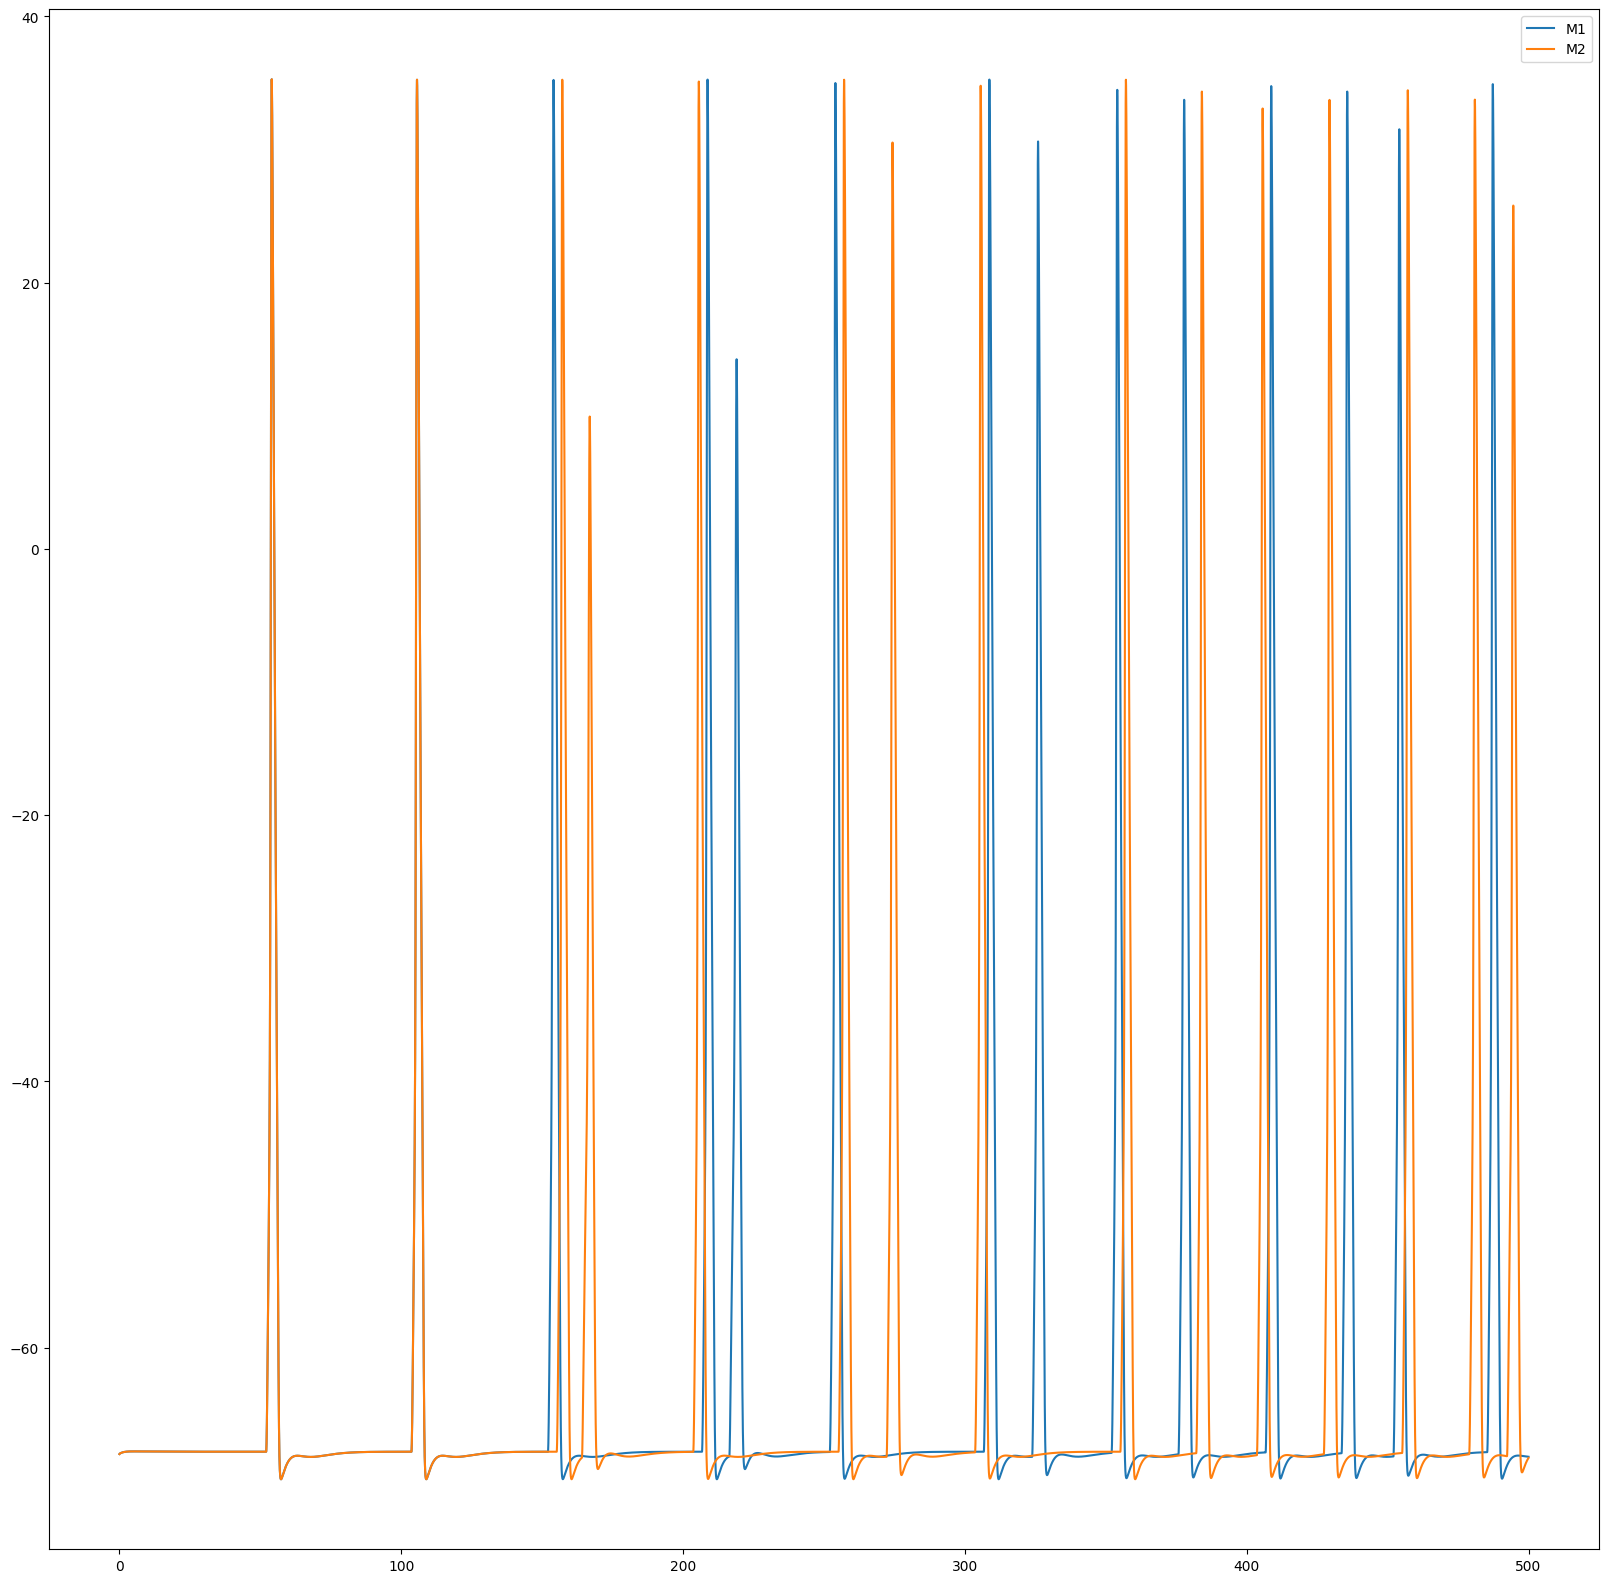

In [220]:

plt.figure(figsize=(20,20))
""" plt.plot(time, vm, label = 'Exc')
plt.plot(time,vm2, label = 'inh')
plt.plot(time,vm3,  label = 'Exc')
plt.plot(time,vm4, label = 'inh') """
plt.plot(time,vm5,  label = 'M1')
plt.plot(time,vm6, label = 'M2')
plt.legend()
plt.ion()


In [221]:

for cellulas in spkss:
    spk = np.array(cellulas)

plt.figure()
plt.eventplot(spkss)
plt.xlabel("Time(ms)")
plt.ylabel("#neuron")
plt.title("Raster Plot")

ValueError: setting an array element with a sequence.

Vector[252]
[[431.999999999844]]
Vector[253]
[[431.999999999844], [433.62499999984254]]
Vector[254]
[[431.999999999844], [433.62499999984254], [433.62499999984254]]
Vector[255]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971]]
Vector[256]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971], [485.19999999979564]]
Vector[257]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971], [485.19999999979564], [485.19999999979564]]
Vector[258]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971], [485.19999999979564], [485.19999999979564], [483.724999999797]]
Vector[259]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971], [485.19999999979564], [485.19999999979564], [483.724999999797], [485.3749999997955]]
Vector[260]
[[431.999999999844], [433.62499999984254], [433.62499999984254], [483.5749999997971], [485.19999999979564], [485.19999

Text(0.5, 1.0, 'Raster Plot')

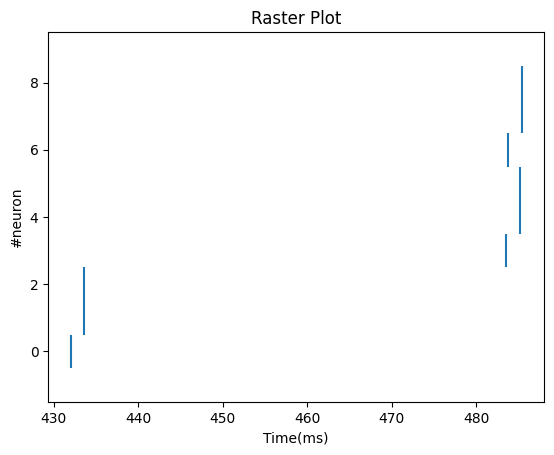